## Interactive Model Training 
Run the cells to reproduce the results

### Data and Models Used in Hisia

**Data:** 2016 TrustPilot's 254,464 Danish reviews' body and stars and [8 fake reviews]*20 see notes for the explanation.<br>
&ensp; _Update_: 2021-10-02: Political Data from [Sentiment Analysis on Comments from Danish Political Articles on Social Media](https://github.com/steffan267/Sentiment-Analysis-on-Danish-Social-Media)

**Models**<br>
Hisia, _LogisticRegression_ with SAGA, a variant of Stochastic Average Gradient (SAG), as a solver. L2 penalty was select for the base model. Test score **accuracy is ca. 93%** and **recall of 93%**. SAGA is a faster solver for large datasets (both rows and columns wise). As a stochastic gradient, the memory of the previous gradient is incorporated/feed-forward to achieve faster convergence rate. Seeds of 42 was set in data split, and 42 in a model for reproducibility.

HisiaTrain, _SGDClassifier_, Stochastic Gradient Descent learner with smooth loss 'modified_huber as loss function and L2 penalty. Test score **accurance  94%** and **recall of 94%**. SGDClassifier was select because of partial_fit. It allows batch/online training.

**Note:** This score reflects models in regards to TrustPilot reviews style of writing.<b>
 >8*10 fake reviews. TrustPilot reviews are directed toward products and services. Words like 'elsker'(love) or 'hader'(hate) are rarely used. To make sure the model learns such a relationship, I added 8 reviews and duplicated them 10 times. These new sentences did not increase or decrease the model accurance but added the correct coefficient of love, hate and (ikke dårligt) not bad.

In [1]:
%reload_ext watermark
%watermark -uniz --author "Author Prayson W. Daniel" -vm -p pandas,numpy,matplotlib,scikit-learn,lemmy,dill

Author: Author Prayson W. Daniel

Last updated: 2022-02-11T12:33:02.742619+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

pandas      : 1.4.0
numpy       : 1.22.2
matplotlib  : 3.5.1
scikit-learn: 1.0.2
lemmy       : 2.1.0
dill        : 0.3.4

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.10.16.3-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



In [2]:
from collections import namedtuple
import joblib
import re
from pathlib import Path

import dill
import lemmy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from loguru import logger

In [4]:
from helpers import show_diagram
from helpers import show_most_informative_features

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight')

This stops were custom made from both unknown Danish stops words and products and services related words such as delivery, package, post office.

In [6]:
PATH_TO_DATA = '../data'
PATH_TO_STOPWORDS = '../hisia/models/data'
STOP_WORDS = joblib.load(f'{PATH_TO_STOPWORDS}/stops.pkl')

The tokenizer separates emojis from the words, removes digits, repetive words and stop words and lemmatize words

In [7]:
lemmatizer = lemmy.load('da')


# Add more stopwords
STOP_WORDS.update({"kilometer", "alme", "bank", "brand", "dansk", "presi"})

In [8]:
"kilometer" in STOP_WORDS

True

In [9]:
def tokenizer(blob, stop_words=STOP_WORDS, remove_digits=True):
    
    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    # 14år --> 14 år
    text = re.sub(r'([0-9]+(\.[0-9]+)?)', r' \1 ', text).strip()
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    text_nostop = [word for word in text.split() if word not in stop_words]
    
    # tokenization lemmatize
    lemmatized_text = [lemmatizer.lemmatize('', word)[-1]  
                                 for word in text_nostop]
    
    remove_stopwords = ' '.join(word for word in lemmatized_text if len(word)>1)
    
    if remove_digits:
        remove_stopwords = re.sub(r'\b\d+\b', '', remove_stopwords)
    

    # remove extra spaces
    remove_stopwords = ' '.join(remove_stopwords .split())
    result = f'{remove_stopwords} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [10]:
tokenizer('Jeg er vred på, at jeg ikke fik min pakke :( kilometer')

['vred', 'ikke', ':(']

In [11]:
df = pd.read_json(f'{PATH_TO_DATA}/data.json')

Fake reviews to teach our model the missing relationsh that is not found in TP reviews

In [12]:
dt = pd.DataFrame([('men elsker elsker', 1,5), 
                   ('elsker det ikke', 0, 1), 
                   ('ikke dårligt', 1, 5),
                   ('elsker skat, kæreste, tilbedte, dyrebare, elskling, darling, hjerte, hjertenskær; ven; veninde', 1, 5),
                   ('dårlig: syg, sløj, utilpas, ilde tilpas, upasselig, snavs, indisponeret;'
                    'sygelig, usund, ond, slet; arg, uheldig, umulig, elendig, under al kritik,'
                    'dødssyg, skidt, skral, krank, ussel, ikke noget at samle på, talentløs, uantagelig,'
                    'uacceptabel, forkastelig; ikke noget at råbe hurra for, ikke noget at skrive hjem om,'
                    'noget skidt (lort, pis), andenklasses, tredjeklasses (osv.), ringe, halvgod, ikke nogen'
                    'ørn til, ikke ens stærke side, ens svage punkt, som en brækket arm; sjusket; ufordelagtig,'
                    'ufyldestgørende, utilstrækkelig, utilfredsstillende, middelmådig, under lavmålet, uduelig,'
                    'udygtig, uhensigtsmæssig, forkert, tarvelig; skadelig, ødelæggende, fordærvet, ubrugelig;'
                    'ubehagelig, væmmelig, ulystbetonet; dys-; utiltalende, usympatisk, kedelig', 0, 1),
                    ('20.000 kroner. Det er, hvad man som arbejdstager burde få ekstra i lønningsposen,'
                    ' hvis man skal kunne acceptere at have en dårlig chef.', 0,1),
                   ('kærlighed, hvordan elsker vi hinanden godt – uanset hvem vi elsker?',1,5),
                   ('jeg hader dig', 0, 1),
                   
                  ]*20, 
                  columns='features target stars'.split())

New data from ["Sentiment Analysis on Comments from Danish Political Articles on Social Media"](https://github.com/lucaspuvis/SAM/blob/master/Thesis.pdf)

In [13]:
SAM = "https://raw.githubusercontent.com/steffan267/Sentiment-Analysis-on-Danish-Social-Media/master/all_sentences.csv"
ds = pd.read_csv(SAM, names=["target", "features"])

In [14]:
ds['target'].value_counts()

 0    4087
-1    2610
 1    1007
-2     862
 2     442
Name: target, dtype: int64

In [15]:
ds.to_json("../data/steffan267_SAM.json")

In [16]:
(
    ds
      .loc[lambda d: d['target'].ne(0), ["target", ]]
      .assign(target= lambda d: np.where(d["target"].gt(0), 1, 0))
      .value_counts()
      .rename(index ={0: "negative", 1:"positive"})
      .to_frame(name="observations")    
)


  

,observations
target,
negative,3472
positive,1449


In [17]:
ds = (
    ds
      .loc[lambda d: d["target"].ne(0), ["features", "target"]]
      .assign(target= lambda d: np.where(d["target"].gt(0), 1, 0))
       
)
  

In [18]:
dt = pd.concat([dt, ds], ignore_index=True)

In [19]:
# dt.to_json('../data/data_custom.json')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['features'], 
                                                     df['target'],
                                                     test_size=.2,
                                                     random_state=42,
                                                     stratify=df['target'])

In [21]:
X_train, y_train = (pd.concat([X_train, dt['features']] ,ignore_index=True),
                    pd.concat([y_train, dt['target']] ,ignore_index=True)
)

In [22]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')
print(f'\nTraing Size\n\tPositive||Negative Samples\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')
print(f'\nTest Size\n\tPositive||Negative Samples\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Traing Size: 208652
Test Size:    50893

Traing Size
	Positive||Negative Samples
	  103315||105337

Test Size
	Positive||Negative Samples
	  25446||25447


In [23]:
hisia = Pipeline(steps =[
        ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                 max_features=150000,
                                 tokenizer=tokenizer, 
                                 stop_words=STOP_WORDS
                                )
        ),
        ('feature_selector', SelectKBest(chi2, k=10000)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('logistic_regression', LogisticRegressionCV(cv=5,
                                                    solver='saga',
                                                    scoring='accuracy',
                                                    max_iter=200,
                                                    n_jobs=-1,
                                                    random_state=42,
                                                    verbose=0))
])

In [24]:
%%time
hisia.fit(X_train, y_train)

/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag

CPU times: user 8min 40s, sys: 938 ms, total: 8min 41s
Wall time: 2min 20s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=150000, ngram_range=(1, 2),
                                 stop_words={'ad', 'af', 'alle', 'alm brand',
                                             'alme', 'alt', 'anden', 'andet',
                                             'andre', 'at', 'bank', 'bare',
                                             'begge', 'besked', 'bestil',
                                             'bestild', 'bestilde', 'bestilden',
                                             'bestilder', 'bestildt',
                                             'bestildte', 'bestile',
                                             'bestilede', 'bestiler',
                                             'bestilet', 'bestilg', 'bestilge',
                                             'bestiling', 'bestilingen',
                                             'bestilinger', ...},
                                 tokenizer=<function tokenizer at 0x7f10d

In [25]:
hisia.score(X_test, y_test)

0.9388521014677853

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94     25447
    Positive       0.95      0.93      0.94     25446

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




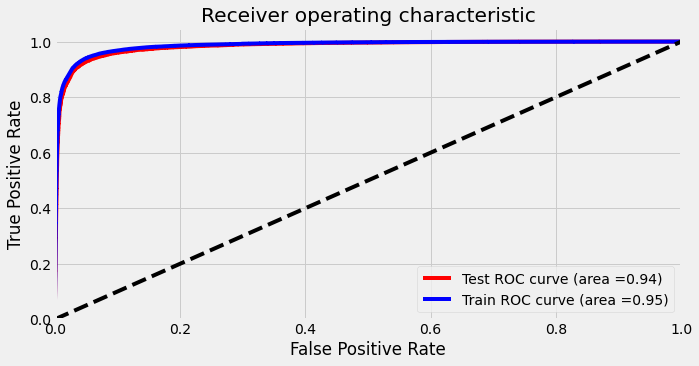

<Figure size 1080x360 with 0 Axes>

In [26]:
show_diagram(hisia, X_train, y_train, X_test, y_test, compare_test=True)

In [27]:
feature_names = hisia.named_steps['count_verctorizer'].get_feature_names_out()
best_features = [feature_names[i] for i in hisia.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia.named_steps['logistic_regression']

In [28]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-9.7399	ikke orden     		8.8074	perfekt        
	-9.0652	uacceptabel    		8.1378	super          
	-8.9101	dårlig         		7.9286	ingen problem  
	-7.3848	elendig        		7.9122	god            
	-6.5459	ikke anbefale  		7.6999	aldrig problem 
	-6.4484	ikke god       		7.5365	fin            
	-6.2361	ikke modtage   		7.3456	nem            
	-6.0789	ikke iorden    		7.3047	hurtig         
	-5.9284	stadig ikke    		6.9515	:-)            
	-5.8047	ikke tilfreds  		6.8843	tilfreds       
	-5.7674	øv             		6.8657	dejlig         
	-5.7114	forkert        		6.7212	sidste stjerne 
	-5.5377	umulig         		6.4038	hurtigt        
	-5.4808	ingen hjælpe   		6.3037	fantastisk     
	-5.4057	påstå          		6.0945	fremragende    
	-5.3715	opsige         		6.0511	ingen klage    
	-5.2554	trætte         		5.6227	varm anbefale  
	-5.2358	ingen måde    

In [29]:
# [negative, positive] probability
hisia.predict_proba(['det er ikke okay!'])

array([[0.92157517, 0.07842483]])

In [30]:
hisia.predict_proba(['det er ikke dårligt!'])

array([[0.31562255, 0.68437745]])

In [31]:
(hisia.predict_proba(['jeg kan lide det!']), 
 hisia.predict_proba(['jeg kan ikke lide det!']),
 hisia.predict_proba(['jeg elsker det!']),
 hisia.predict_proba(['jeg elsker det slet ikke!'])
)

(array([[0.30794862, 0.69205138]]),
 array([[0.92157517, 0.07842483]]),
 array([[0.14457541, 0.85542459]]),
 array([[0.69046507, 0.30953493]]))

In [32]:
mad_max = ['Jeg er vred på, at jeg ikke fik min pakke :( elsker']

In [33]:
hisia.named_steps['logistic_regression'].random_state

42

In [34]:
hisia.predict_proba(['']) # model is positive :)

array([[0.30794862, 0.69205138]])

In [35]:
hisia.predict(mad_max)

array([0])

In [36]:
res = hisia.predict_proba(mad_max)
res

array([[0.93994632, 0.06005368]])

In [37]:
hisia.decision_function(mad_max)

array([-2.75058403])

In [38]:
v = hisia.named_steps['count_verctorizer'].transform(mad_max)
v = hisia.named_steps['feature_selector'].transform(v)
v = pd.DataFrame.sparse.from_spmatrix(v)

In [93]:
v = set(v.T.loc[v.eq(1).values[0]].index)

In [39]:
look_up = {index:(token,coef) for index, coef, token in 
           zip(range(len(best_features)),
               hisia.named_steps['logistic_regression'].coef_[0], 
               best_features)}

In [94]:
{look_up[item] for item in v}

{(':(', -4.36432604514099),
 ('elsker', 0.9680694667216431),
 ('ikke', -3.273671001915033),
 ('vred', -2.315838584847349)}

In [41]:
hisia.named_steps['logistic_regression'].intercept_[0]

0.809727254639209

In [95]:
g = [look_up[item] for item in v]

In [98]:
sum(i for _, i in g)

-8.98576616518173

𝑓(𝐱): 𝑝(𝐱) = 1 / (1 + exp(−𝑓(𝐱))

In [101]:
1/(1 + np.exp(-(sum(i for _, i in g) + hisia.named_steps['logistic_regression'].intercept_[0])))

0.000281234930865107

In [44]:
hisia.decision_function(mad_max)[0]

-2.7505840252763147

In [45]:
df = pd.DataFrame(res)

In [46]:
df['sentiment'] = np.where(df[0] > .5, 'negative', 'positive')

df.columns = ['negative_probability','positive_probability','sentiment']

Sentiment = namedtuple('Sentiment', ['sentiment','positive_probability', 'negative_probability'])

df

,negative_probability,positive_probability,sentiment
0,0.939946,0.060054,negative


In [47]:
b = Sentiment(**df.round(3).to_dict(orient='index')[0])

In [48]:
b

Sentiment(sentiment='negative', positive_probability=0.06, negative_probability=0.94)

# Retrainable Model SGD

In [49]:
hisia_trainer =Pipeline(steps =[
                ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                         max_features=100000,
                                         tokenizer=tokenizer, 
                                        )
                ),
                ('feature_selector', SelectKBest(chi2, k=5000)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern', SGDClassifier(loss='modified_huber', 
                                                      random_state=7,
                                                      max_iter=1000))
])

In [50]:
%%time
hisia_trainer.fit(X_train, y_train)

CPU times: user 38 s, sys: 260 ms, total: 38.2 s
Wall time: 38.3 s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=100000, ngram_range=(1, 2),
                                 tokenizer=<function tokenizer at 0x7f10d8012a60>)),
                ('feature_selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7f10f4a3bee0>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern',
                 SGDClassifier(loss='modified_huber', random_state=7))])

In [51]:
# for partil_fit we have to split the pipeline to transformation and scoring
hisia_trainer.score(X_test,y_test)

0.9346472009903131

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.92      0.96      0.94     25447
    Positive       0.95      0.91      0.93     25446

    accuracy                           0.93     50893
   macro avg       0.94      0.93      0.93     50893
weighted avg       0.94      0.93      0.93     50893

	 _____________________________________________ 




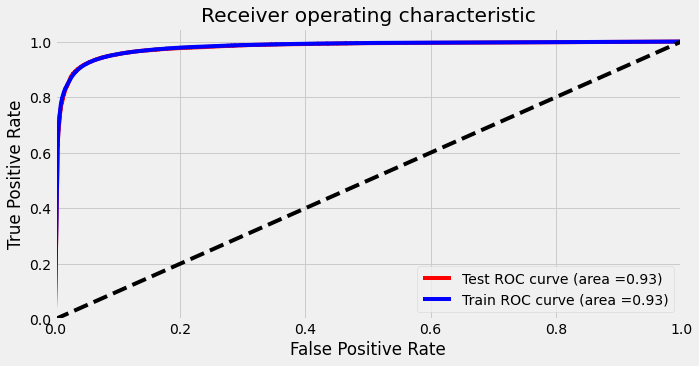

<Figure size 1080x360 with 0 Axes>

In [52]:
show_diagram(hisia_trainer, X_train, y_train, X_test, y_test, compare_test=True)

In [53]:
feature_names = hisia_trainer.named_steps['count_verctorizer'].get_feature_names()
best_features = [feature_names[i] for i in hisia_trainer.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia_trainer.named_steps['modified_hubern']

/home/pwd/.cache/pypoetry/virtualenvs/hisia-0TdsdPxg-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [54]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-2.4296	dårlig         		2.0786	god            
	-1.8727	ikke orden     		2.0763	hurtig         
	-1.7033	uacceptabel    		2.0737	super          
	-1.6897	elendig        		2.0287	perfekt        
	-1.6492	ikke god       		1.9509	nem            
	-1.6048	kilometer      		1.9187	fin            
	-1.5178	først          		1.8950	dejlig         
	-1.4198	forkert        		1.8171	tilfreds       
	-1.3975	langsom        		1.7876	hurtigt        
	-1.3890	ikke modtage   		1.7450	:-)            
	-1.3853	ikke tilfreds  		1.6015	fantastisk     
	-1.3480	forsøge        		1.4896	:)             
	-1.3428	øv             		1.3066	smile          
	-1.3225	ikke           		1.2744	venlig         
	-1.2833	ødelægge       		1.2192	ingen problem  
	-1.2632	betale         		1.2007	fremragende    
	-1.2588	trætte         		1.1829	ikke dårlig    
	-1.2477	uge           